In [1]:
import sys; sys.path.append('..')
import random
import pyzx as zx
from pyzx.linalg import *
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

In [2]:
qubits = 20

random.seed(1337)

for i in range(100):
    if i % 10 == 0:
        print("NO FAILURES AFTER", i, "ITERATIONS")
    seed = random.randint(0, 20000)
    random.seed(seed)
    circ = zx.generate.cliffordT(qubits, 100, p_t=0.2)
    zx.clifford_simp(circ, quiet=True)
    #zx.drawing.pack_circuit_ranks(circ)
    g = circ.copy()
    if not zx.extract.greedy_cut_extract(g, qubits):
        print("GOT FAILURE ON ITERATION", i, "RANDOM SEED", seed)
        break
print("FINISHED")


NO FAILURES AFTER 0 ITERATIONS
NO FAILURES AFTER 10 ITERATIONS
NO FAILURES AFTER 20 ITERATIONS
NO FAILURES AFTER 30 ITERATIONS
NO FAILURES AFTER 40 ITERATIONS
NO FAILURES AFTER 50 ITERATIONS
NO FAILURES AFTER 60 ITERATIONS
NO FAILURES AFTER 70 ITERATIONS
NO FAILURES AFTER 80 ITERATIONS
NO FAILURES AFTER 90 ITERATIONS
FINISHED


In [2]:
qubits = 8

random.seed(240)

circ = zx.generate.cliffordT(qubits, 300, p_t=0.1)
zx.clifford_simp(circ)

spider_simp
84. 57. 34. 20. 16. 8. 1. 
finished in 8 iterations
pivot_simp
23. 10. 2. 1. 
finished in 5 iterations
lcomp_simp
46. 15. 12. 6. 4. 5. 3. 1. 1. 
finished in 10 iterations
pivot_simp
2. 1. 
finished in 3 iterations
id_simp

finished in 1 iterations


In [7]:
print(zx.t_count(circ))
print(circ.num_vertices() - 8 * 4)

21
19


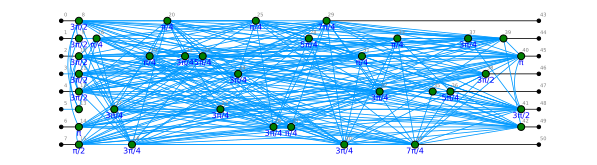

In [6]:
g = circ.copy()
zx.pack_circuit_ranks(g)
zx.draw(g, labels=True)

In [7]:
zx.extract.single_cut_extract(g, 8)

True

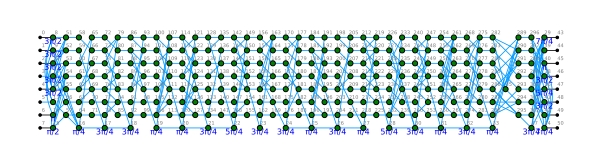

In [8]:
zx.drawing.pack_circuit_ranks(g)
zx.draw(g, labels=True)

In [57]:
def gadgetize(g, qubits):
    newv = g.vindex
    for v in list(g.vertices()):
        va = g.get_angle(v)
        vt = g.get_type(v)
        vq = g.get_vdata(v,'q')
        vr = g.get_vdata(v,'r')
        if va.denominator > 2:
            g.set_angle(v, 0)
            
            g.add_vertex()
            g.set_type(newv, 2)
            g.set_vdata(newv, 'q', qubits)
            g.set_vdata(newv, 'r', vr)
            newv+=1
            
            g.add_vertex()
            g.set_type(newv, vt)
            g.set_angle(newv, va)
            g.set_vdata(newv, 'q', qubits+1)
            g.set_vdata(newv, 'r', vr)
            newv += 1
            
            g.add_edges([(v,newv-2),(newv-2,newv-1)])

In [13]:
zx.spider_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
gadgetize(circ)

spider_simp

finished in 1 iterations


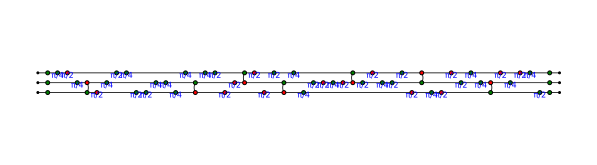

In [74]:
zx.draw(circ)

In [3]:
random.seed(1337)
circ = zx.examples.cliffordT(3, 1000, p_t=0.02)
print('t-count:', zx.t_count(circ))
zx.clifford_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
print('t-count:', zx.t_count(circ))

t-count: 11
spider_simp
260. 185. 113. 64. 37. 13. 7. 2. 1. 
finished in 10 iterations
pivot_simp
75. 36. 11. 2. 
finished in 5 iterations
lcomp_simp
168. 60. 46. 33. 25. 15. 10. 8. 4. 4. 3. 3. 3. 2. 3. 2. 2. 2. 1. 2. 2. 1. 
finished in 23 iterations
pivot_simp
1. 
finished in 2 iterations
t-count: 7


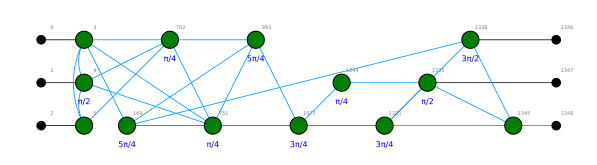

In [4]:
zx.draw(circ, labels=True)

In [12]:
# WORKS
#random.seed(1337)
#circ = zx.examples.cliffordT(4, 400, p_t=0.1)

# WORKS
random.seed(140)
circ = zx.examples.cliffordT(4, 40, p_t=0.5)
print('t-count:', zx.t_count(circ))
zx.clifford_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
print('t-count:', zx.t_count(circ))

t-count: 15
spider_simp
11. 7. 5. 1. 1. 1. 
finished in 7 iterations
pivot_simp
1. 1. 
finished in 3 iterations
lcomp_simp
9. 1. 1. 1. 
finished in 5 iterations
pivot_simp

finished in 1 iterations
t-count: 5


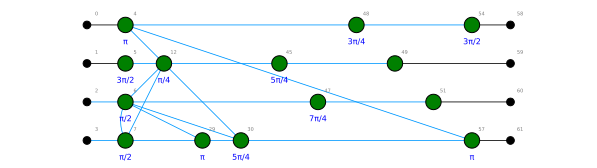

In [13]:
zx.draw(circ, labels=True)

terminated normally


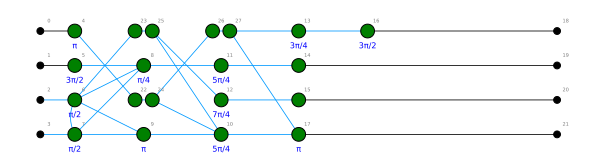

In [15]:
g = circ.copy()
zx.cut_extract(g,4)
zx.draw(g, labels=True)

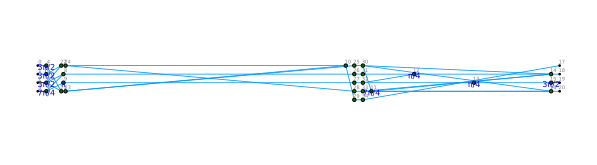

In [3]:
#g = circ.copy()
#zx.pack_circuit_ranks(g)
zx.draw(g,labels=True)

In [10]:
zx.extract.after(g,[8,21,22,23])
zx.extract.bi_adj(g,[8,21,22,23],[10, 25, 26, 27]).rank()

4

In [11]:
zx.clifford_simp(g)

spider_simp

finished in 1 iterations
pivot_simp
4. 2. 2. 1. 
finished in 5 iterations
lcomp_simp
1. 
finished in 2 iterations
pivot_simp

finished in 1 iterations


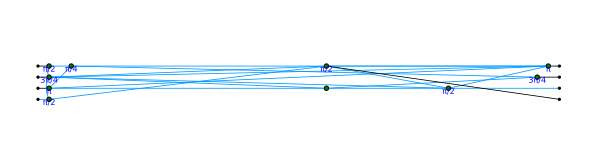

In [12]:
zx.draw(g)

In [5]:
qubits = 4

random.seed(240)

for i in range(126):
    circ = zx.generate.cliffordT(qubits, 40, p_t=0.1)
circ = zx.generate.cliffordT(qubits, 40, p_t=0.1)
zx.clifford_simp(circ)
g = circ.copy()
#zx.cut_extract(g,qubits)

spider_simp
11. 7. 4. 3. 1. 
finished in 6 iterations
pivot_simp
4. 3. 
finished in 3 iterations
lcomp_simp
7. 2. 1. 
finished in 4 iterations
pivot_simp
2. 
finished in 2 iterations
id_simp

finished in 1 iterations


[8, 9, 10, 11, 14, 16]
2
[10, 11, 12, 13, 14, 16]
1


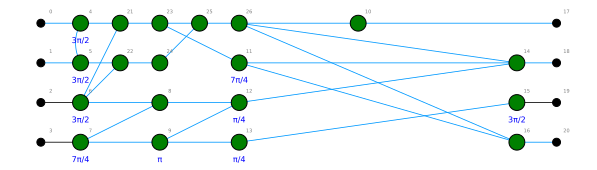

In [20]:
g = circ.copy()
zx.pack_circuit_ranks(g)
print(zx.extract.after(g, [4,5,6,7]))
print(zx.extract.bi_adj(g, [4,5,6,7], [10, 11, 14, 16]).rank())
zx.extract.cut_edges(g, [4,5,6,7], [10, 11, 14, 16])
g.set_vdata(8, 'r', 3)
g.set_vdata(8, 'q', 2)
g.set_vdata(9, 'r', 3)
g.set_vdata(9, 'q', 3)
print(zx.extract.after(g,set([8,9,23,24])))
print(zx.extract.bi_adj(g,[8,9,23,24],[10,14,16]).rank())
zx.extract.cut_edges(g,[8,9,23,24],[10,14,16])
g.set_vdata(11, 'r', 5)
g.set_vdata(11, 'q', 1)
g.set_vdata(12, 'r', 5)
g.set_vdata(12, 'q', 2)
g.set_vdata(13, 'r', 5)
g.set_vdata(13, 'q', 3)
zx.draw(g,labels=True)

In [31]:
s = set([1,2,3])
s.add(4)
s

{1, 2, 3, 4}

In [5]:
g.get_vdata(0,'i')

0

In [33]:
row = [1,4,3,2]
list.sort(row)
row

[1, 2, 3, 4]

In [10]:
range(3,6)[1]

4